Импорт библиотек

In [5]:
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

import nltk
from nltk.corpus import stopwords
import spacy
import langid

import plotly
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

init_notebook_mode(connected=True)
cf.set_config_file(sharing='public',theme='white',offline=True)

import fastbook
fastbook.setup_book()

from fastai.text.all import *
from fastbook import *

import warnings 
warnings.filterwarnings('ignore')

Загрузка датасета


In [6]:
train = pd.read_csv('train.csv', header=None, names=['label', 'title', 'text'])
test = pd.read_csv('test.csv', header=None, names=['label', 'title', 'text'])

In [7]:
train['title'].fillna('', inplace=True)
test['title'].fillna('', inplace=True)

train_len = 50000
test_len = 10000
rs = 42

df = pd.concat([train.loc[train['label'] == 1].sample(train_len//2, random_state=rs),
                train.loc[train['label'] == 2].sample(train_len//2, random_state=rs),
                test.loc[test['label'] == 1].sample(test_len//2, random_state=rs),
                test.loc[test['label'] == 2].sample(test_len//2, random_state=rs)]).reset_index(drop=True)
df['text'] = df['title'] + '. ' + df['text']
df.drop('title', axis=1, inplace=True)
df.head()

,label,text
0,1,"The History of Torture and Execution. I have not yet received the book ordered even though, I paid a rather high price for it. I have been unable to get a response from the seller, and am beginning to think that they may be something ""less than reputable"".James J. EbyRATING- ""ZERO STARS""!"
1,1,"Stainless Steel shouldn't corrode... should it?. We were really pleased when we first received and used this knife set. Its appearance was very professional, the handles very user friendly, and the edges were VERY sharp. However, after using the set and following the care directions for a few months, it became apparent that something was VERY wrong. The 3 1/4"" and 5"" blades started to show black spots and then began to corrode. Now the 3 1/4"" paring knife blade has so much decay that it can be nearly described as a serrated blade. The manufacturer offers a ""limited lifetime warranty"" so we..."
2,1,Another Weak Sequel To A Once Promising Franchise. Hellraiser: Heatseeker is a film that I wanted to enjoy. I thought the first direct to video Hellraiser sequel was decent but this one is just patheic consdering it has Ashley Laurence in it. I would only say you see this film if you need a movie to fall asleep on.
3,1,"Simply Awful. Contrived, trite, ""Bridget Jones's Diary"" wannabe. So glad that I borrowed this from the library and did not spend hard-earned cash. A frivolous story about a London plain Jane and her struggles to land the boy - and career - of her dreams. 291 pages of pure fluff."
4,1,"FLASH. Jeff Beck's Flash In my opinion, was not one of his better albums.""Gets us all in the end"" is a hard driving rocker.""People Get Ready"" with Rod Stewart on vocals is a Classic!Take these 2 tracks out of there, and this was a new sound experimentgone south! Too much of that New Wave sound which was becoming increasinglypopular in the 80's. Just not my cup of tea.But if that sound is you Go for it! Jeff Beck is still one of the All timebest Guitarist's that ever played an ax."


Количество меток

In [8]:
print(f'количество меток- обучающий набор:\n{df[:train_len].label.value_counts()}')
print(f'\nколичество меток - набор для теста:\n{df[train_len:].label.value_counts()}')

количество меток- обучающий набор:
label
1    25000
2    25000
Name: count, dtype: int64

количество меток - набор для теста:
label
1    5000
2    5000
Name: count, dtype: int64


Количество отзывов из одного - трех слов

In [9]:
cv = CountVectorizer(ngram_range=(1,3))
cv.fit(df['text'])
print(f"Количество отзывоы из одного- трех слов: {len(cv.vocabulary_)}")

Количество отзывоы из одного- трех слов: 4212001


Находим н-грамы и строим модель

In [10]:
spis = cv.get_feature_names_out()
preobr = cv.transform(df['text'])
gram_counts = np.array(preobr.sum(0)).squeeze()

gram_counts_df = pd.DataFrame({'n-gram': [spis[i] for i in gram_counts.argsort()],
                               'count': sorted(gram_counts)})

px.bar(gram_counts_df[-20:], y='n-gram', x='count', title='чаще встречающиеся н-грамы', orientation='h', height=600)

Векторизация

Model: CountVectorizer + MultinomialNB
Количество функций: 3615732
Точность: 0.8906

              precision    recall  f1-score   support

           1       0.87      0.92      0.89      5000
           2       0.92      0.86      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



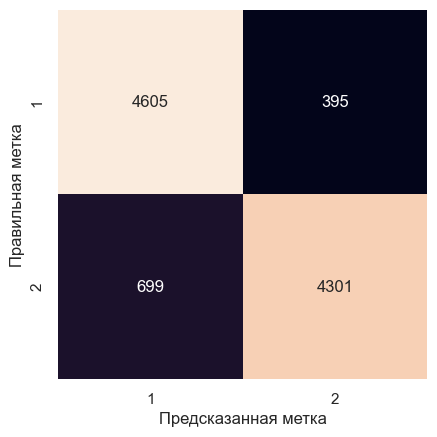

In [11]:
cv_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), MultinomialNB())

x_train, y_train = df['text'][:train_len], df['label'][:train_len].values.reshape(-1,1)
x_test, y_test = df['text'][train_len:], df['label'][train_len:].values.reshape(-1,1)

cv_model.fit(x_train, y_train)
preds = cv_model.predict(x_test)

print("Model: CountVectorizer + MultinomialNB")
print(f"Количество функций: {len(cv_model[0].vocabulary_)}")
print("Точность: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=cv_model.classes_, yticklabels=cv_model.classes_)
plt.xlabel('Предсказанная метка')
plt.ylabel('Правильная метка')

print(classification_report(y_test, preds, labels=cv_model.classes_))

Model: TfidfVectorizer + MultinomialNB
Number of features: 3615732
Accuracy: 0.8908

              precision    recall  f1-score   support

           1       0.86      0.93      0.89      5000
           2       0.92      0.85      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



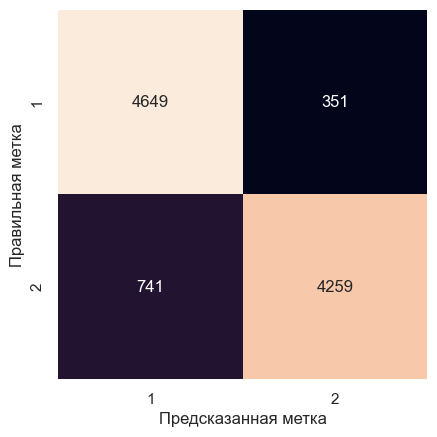

In [12]:
tfidf_model = make_pipeline(TfidfVectorizer(ngram_range=(1,3)), MultinomialNB())

tfidf_model.fit(x_train, y_train)
preds = tfidf_model.predict(x_test)

print("Model: TfidfVectorizer + MultinomialNB")
print(f"Number of features: {len(tfidf_model[0].vocabulary_)}")
print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=tfidf_model.classes_, yticklabels=tfidf_model.classes_)
plt.xlabel('Предсказанная метка')
plt.ylabel('Правильная метка')


print(classification_report(y_test, preds, labels=tfidf_model.classes_))

Подготовка данных, создание DataLoaders и отображение батча

In [13]:
lm_dblock = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                   get_x=ColReader('text'),
                   splitter=IndexSplitter(range(train_len, len(df))))
lm_dls = lm_dblock.dataloaders(df, bs=32, seq_len=72)

lm_dls.show_batch(dataloaders=lm_dls, max_n=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


,text,text_
0,"xxbos fun & informative . xxmaj this book reminds me of another good poker book , xxmaj all xxmaj in by xxmaj jonathan xxmaj xxunk & xxmaj storms xxmaj xxunk . xxmaj it a little bit of many different things . xxmaj there 's poker advice , poker history , biographies , poker stories , and humor . xxmaj it 's a great book for someone who wants to learn a thing","fun & informative . xxmaj this book reminds me of another good poker book , xxmaj all xxmaj in by xxmaj jonathan xxmaj xxunk & xxmaj storms xxmaj xxunk . xxmaj it a little bit of many different things . xxmaj there 's poker advice , poker history , biographies , poker stories , and humor . xxmaj it 's a great book for someone who wants to learn a thing or"
1,"1.7 oz . and 3.4 oz . sprays , it promises to be a highly coveted fragrance at an affordable price . xxbos xxmaj the best ever xxrep 3 ! . xxmaj well i bought this with my own money i am 15 and i love it . xxmaj my mom has a mp3 player that she got a year ago and this thing out plays it by a xxunk love it","oz . and 3.4 oz . sprays , it promises to be a highly coveted fragrance at an affordable price . xxbos xxmaj the best ever xxrep 3 ! . xxmaj well i bought this with my own money i am 15 and i love it . xxmaj my mom has a mp3 player that she got a year ago and this thing out plays it by a xxunk love it ."
2,"'s current theme . xxmaj this is mainly good for xxmaj taker 's current theme which is on the dvd . xxbos seriously overpriced . xxmaj toby xxmaj wilkinson , a well - respected young xxmaj british xxmaj egyptologist , has gathered together all known published information about the xxmaj palermo xxmaj stone and 6 other associated fragments and added a little of his own . xxmaj the resulting text is spread","current theme . xxmaj this is mainly good for xxmaj taker 's current theme which is on the dvd . xxbos seriously overpriced . xxmaj toby xxmaj wilkinson , a well - respected young xxmaj british xxmaj egyptologist , has gathered together all known published information about the xxmaj palermo xxmaj stone and 6 other associated fragments and added a little of his own . xxmaj the resulting text is spread thinly"
3,"time and i have to say it really has brought us together . xxmaj it 's a great laugh , every time . xxmaj it arrived quickly and we promptly put it in . xxbos xxmaj gas xxmaj engine xxmaj repair . xxmaj this book is way too general . xxmaj if you want a repair manual for your engine , buy one . xxmaj this ai n't it . xxbos i","and i have to say it really has brought us together . xxmaj it 's a great laugh , every time . xxmaj it arrived quickly and we promptly put it in . xxbos xxmaj gas xxmaj engine xxmaj repair . xxmaj this book is way too general . xxmaj if you want a repair manual for your engine , buy one . xxmaj this ai n't it . xxbos i really"


Создание модели и поиск подходящей скорости обучения

SuggestedLRs(valley=0.001737800776027143)

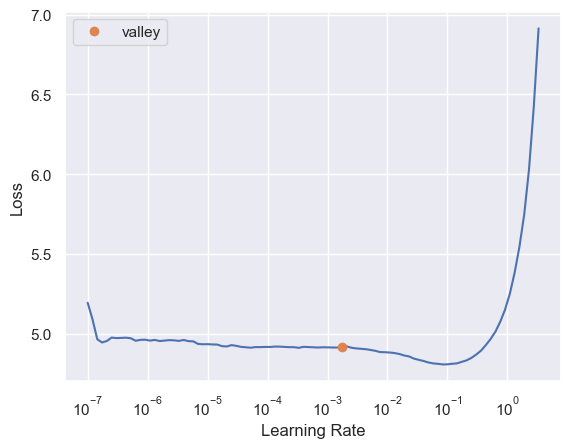

In [14]:
lm_learn = language_model_learner(lm_dls, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, perplexity])
lm_learn.lr_find()

Обучение модели 

In [15]:
lm_learn.fit_one_cycle(3, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.181947,4.103912,0.272017,60.576794,1:30:16
1,4.006105,3.992933,0.284250,54.213654,1:28:29
2,3.788312,3.954174,0.288792,52.152576,1:28:26


Определение DataBlock для классификации текста, создание DataLoaders для классификации текста и отображение батча

In [16]:
lm_learn.save_encoder('lstm_finetuned')

clas_dblock = DataBlock(blocks=(TextBlock.from_df('text', vocab=lm_dls.vocab), CategoryBlock),
                        get_x=ColReader('text'), get_y=ColReader('label'),
                        splitter=IndexSplitter(range(train_len, len(df))))

clas_dls = clas_dblock.dataloaders(df, bs=32, seq_len=72, dl_type=SortedDL)

clas_dls.show_batch(dls=clas_dls, max_n=5)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


,text,category
0,"xxbos xxup not xxup the xxup best xxup one , xxup but xxup close ( plus its only 12 bucks ) . … xxup the xxup audio xxup has xxup been xxup altered . xxup this xxup is xxup not xxup ac / xxup dc xxup live , xxup its xxup ac / xxup dc xxup xxunk . xxup the xxup nice xxup part xxup is xxup that xxup it xxup sounds xxup fantastic ! ! xxup the xxup audio xxup is xxup darn xxup near xxup perfect . xxup however , xxup the xxup video xxup quality xxup is xxup vhs xxup at xxup best , xxup the xxup blacks xxup look xxup grey xxup and xxup worn . xxup what xxup else xxup would xxup you xxup expect xxup from a 1991 xxup concert ? xxup some xxup remastering xxup would xxup have xxup been xxup nice .",2
1,xxbos xxmaj excellent xxmaj camcorder xxmaj bag . i found this bag to have plenty of room and very sturdy . i have in it the following:1 . xxmaj sony xxup dcr - xxunk xxmaj xxunk . xxmaj sony xxup dvd xxmaj adaptor / xxmaj xxunk . xxmaj sony xxup dvd xxmaj travel xxmaj xxunk . 2 xxmaj sony xxup dvd h xxmaj series xxmaj batteries ( 1 of xxup np - xxunk & 1 of xxup np - xxunk . 1 xxmaj sony xxup dvd xxmaj wide xxmaj angle xxmaj lens in xxunk . 1 xxmaj sony xxup dvd xxmaj telephoto xxmaj lens in xxunk . 1 xxmaj sony xxup dvd xxmaj polarizing xxmaj filter xxmaj xxunk . xxmaj sony xxup dvd xxmaj high xxmaj grade xxup av xxmaj xxunk . 4 xxmaj blank mini - dvd - rw xxmaj xxunk . xxmaj lens cleaning xxunk . xxmaj memory,2
2,"xxbos xxmaj salsa music for "" true xxmaj salsa xxmaj lovers "" . xxmaj we went for the first time to see / hear xxmaj charlie xxmaj cruz sing live his hits at a xxmaj state xxmaj fair in xxmaj jersey . xxmaj we never xxunk that we would truly enjoyed his music and band ; they are truly good . xxmaj we love xxmaj salsa and we just wanted to dance or go dancing after he sang . xxmaj we enjoyed his talent , he loves to dance , talk to the public and we loved that he 's also a xxmaj new xxmaj jersey / xxmaj new xxmaj york xxmaj puerto xxmaj rican , too . xxmaj we also enjoyed hearing that he was bought up in the same town as "" frankie xxmaj ruiz "" . xxmaj hearing him sing some of xxmaj frankie 's songs was",2
3,"xxbos xxmaj good start for your xxmaj sheena collection . xxmaj here we have yet another collection . a great start for anyone interested in xxmaj sheena xxmaj easton . xxmaj this time the xxup cd is remastered . xxmaj this brings new life to some of the details missed in previous collections . xxmaj unfortunately the xxup cd is missing the actual last hit for xxmaj sheena on xxup emi "" eternity "" a prince penned song.this set has a nice biography section with chart positions . xxmaj today 's female vocalists could learn a thing or two from this ballad princess who does n't have to go up and down the scales fifty times to show emotion . xxmaj just listen to "" when xxmaj he xxmaj shines "" or "" almost xxmaj over xxmaj you "" and the great "" you xxmaj could xxmaj have xxmaj been",2
4,"xxbos xxmaj christina xxmaj bald 's review . xxmaj in "" xxmaj one of xxmaj those xxmaj hideous xxmaj books xxmaj where xxmaj the xxmaj mother xxmaj dies . "" xxmaj there is a girl named xxmaj ruby who moved to la , california . xxmaj her mother dies and she is forced to live with her father . xxmaj she 's upset because her aunt and uncle could nt take her in . xxmaj ruby 's father told her to come live with him . xxmaj she left everything xxunk ever known , ever loved . xxmaj she finds out that her boyfriend xxmaj ray hooks up with her best friend xxmaj lizzy . xxmaj also that she has new problems , she begins to hate her mother for xxunk did nt really like this book because it does nt really relate to me , in any way .",1


Обучение модели и поиск подходящей скорости обучения

SuggestedLRs(valley=0.0030199517495930195)

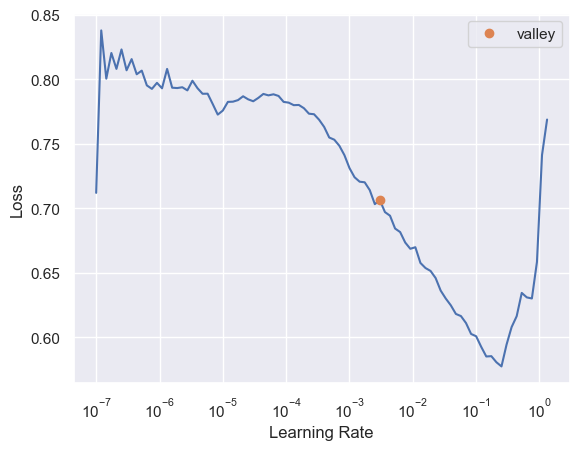

In [17]:
clas_learn = text_classifier_learner(clas_dls, AWD_LSTM, seq_len=72, metrics=accuracy)
clas_learn.load_encoder('lstm_finetuned')
clas_learn.freeze()

clas_learn.lr_find()

Обучение модели с использованием стратегии "одного цикла" (One Cycle Policy)

In [18]:
clas_learn.fit_one_cycle(1, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.374873,0.288534,0.883300,17:38


SuggestedLRs(valley=3.630780702224001e-05)

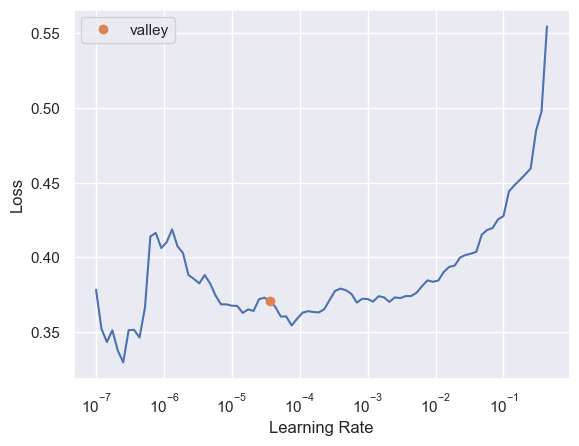

In [19]:
clas_learn.freeze_to(-2)
clas_learn.lr_find()

In [20]:
clas_learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.346327,0.279465,0.884900,21:57


SuggestedLRs(valley=0.0008317637839354575)

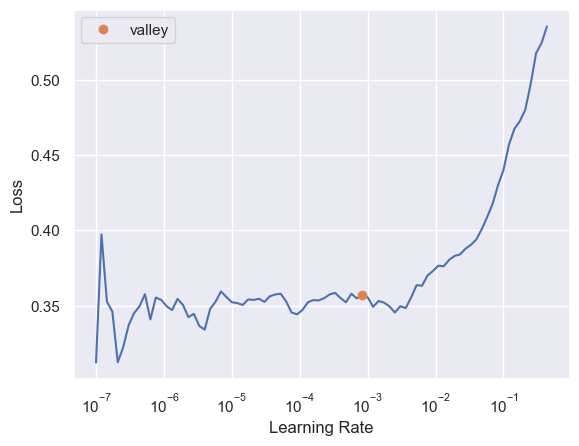

In [21]:
clas_learn.unfreeze()
clas_learn.lr_find()

In [25]:
clas_learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.298662,0.221510,0.909300,52:54
1,0.258787,0.213280,0.914600,53:17
2,0.265962,0.210399,0.917700,53:05


Интерпритация результатов классификации 

              precision    recall  f1-score   support

           1       0.91      0.91      0.91      5000
           2       0.91      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



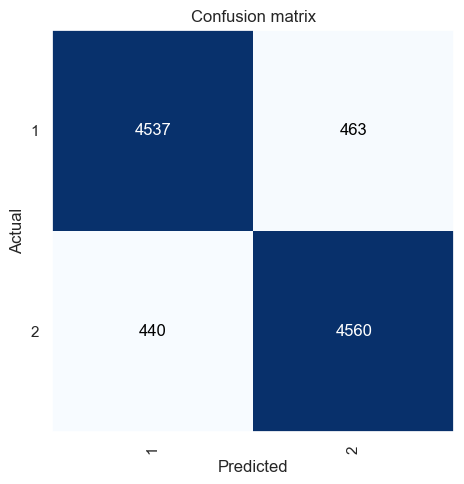

In [23]:
interp = ClassificationInterpretation.from_learner(clas_learn)

interp.print_classification_report()
interp.plot_confusion_matrix()

In [24]:
interp.plot_top_losses(k=8)

,input,target,predicted,probability,loss
0,"xxbos typos galore ! . i do not intend to review content here . xxmaj this new edition is so full of typographical errors that sometimes the reader will have to intuit what the author really wrote . xxmaj it is clear that the proofreaders of this edition were not actually reading ; they were simply following the little red lines under the "" misspelled "" words . xxmaj this has resulted in some truly bizarre apparent statements by the author , xxunk here due to copyright laws . xxmaj xxunk i have not purchased this book , merely checked it out of the library .",2,1,0.9991006851196289,9.39915943145752
1,"xxbos xxmaj excellent ! . xxmaj this is one of the best books xxmaj i 've read on the subject . xxmaj everyone who is involved in any type of business research or competitor research can benefit from this book . xxmaj it even includes detailed descriptions of some of the best business information resources available , on- and offline .",1,2,0.9994290471076965,8.851884841918945
2,xxbos xxmaj excellent . xxmaj this is a great book . xxmaj martha xxmaj beck is a wonderful writer with clear insight . a must read for anyone seeking their true path in life .,1,2,0.9998568296432495,7.468233108520508
3,xxbos outstanding . xxmaj five stars ! . xxmaj excellent instructions for applique with pictures to demonstrate their words . xxmaj basic applique primer . xxmaj your resource book .,1,2,0.9938521385192871,7.013862133026123
4,xxbos xxmaj great easy to use . xxmaj have nt used yet but plan on soon it looks easy to use and i will soon but just have nt yet,1,2,0.9952235817909241,6.992678165435791
5,"xxbos xxmaj nice device for xxunk use . i would greatly appreciate being able to cite page numbers for essays , as well as gain access to all footnotes .",1,2,0.9905202388763428,6.31151008605957
6,"xxbos xxmaj good xxmaj ones . i bought these for my kids toys , been using these for almost 2 months now.i am happy with the product .",1,1,0.6755302548408508,6.20820426940918
7,xxbos xxmaj sensational . xxmaj this book is a riveting tale of suspense and adventure . xxmaj the ending made me cry . xxmaj beautiful !,1,1,0.6755302548408508,5.995362758636475
